# Inputs & Functions

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2121)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
def triple_regplot(features, target, data):
    '''
    Takes a list of three feature names from dataset data and performs
    sns regplots of each against target feature "target" 
    and titles each with the feature's correlation with target
    '''
    
    fig, ax = plt.subplots(1,3,figsize=(21,7))
    
    sns.regplot(x=features[0], y=target, data=data,
                scatter_kws={'alpha':0.2},
                line_kws={'color': 'red'},
                ax=ax[0])\
    .set(title=target+' vs '+features[0]+'\nCorr:'+\
         str(round(data.corr().loc[target,features[0]],2)))
    
    sns.regplot(x=features[1], y=target, data=data,
            color='rebeccapurple',
            scatter_kws={'alpha':0.2},
            line_kws={'color': 'red'},
            ax=ax[1])\
    .set(title=target+' vs '+features[1]+'\nCorr:'+\
         str(round(data.corr().loc[target,features[1]],2)))

    sns.regplot(x=features[2], y=target, data=data,
                color='darkseagreen',
                scatter_kws={'alpha':0.2},
                line_kws={'color': 'red'},
                ax=ax[2])\
    .set(title=target+' vs '+features[2]+'\nCorr:'+\
         str(round(data.corr().loc[target,features[2]],2)))

In [3]:
batpos = pd.read_csv('../data/batpos_feature_extracted.csv')

# Approach

As mentioned in 02_Feature_Extraction_and_Cleaning, two approaches are being used to preprocess the data for modeling. The first was a holistic view that was used in workbooks 02-04. The second one we will dub RDF_YDF.

The general approach will be to split our batpos dataframe we got right after creating the lookback variables into:
  -  Runs features (RDF)
  -  Year features (YDF)
  -  Other features (not RDF or YDF)
  
The ultimate goal is to improve our modeling by removing noise when modeling the *components* of `waa_pg`, and then combining those models to ultimately model `waa_pg`.

# RDF Creation

The first partition of our dataframe will deal with Runs features (RDF).

In [4]:
rdf = batpos.copy()

## Target Variable

Runs are the building blocks of wins. This approach bets on modeling those building blocks specifically will lead to a better model of wins and waa_pg.

The target variable for RDF will be `runs_total_pg` which is the linear combination of runs variables:
```python
runs_total_pg = runs_bat_pg + runs_br_pg + runs_dp_pg + runs_defense_pg + runs_position_pg
```

In [5]:
# create RDF target variable
rdf['runs_total_pg'] = rdf['runs_bat_pg']+rdf['runs_br_pg']+\
                          rdf['runs_dp_pg']+rdf['runs_defense_pg']+\
                          rdf['runs_position_pg']

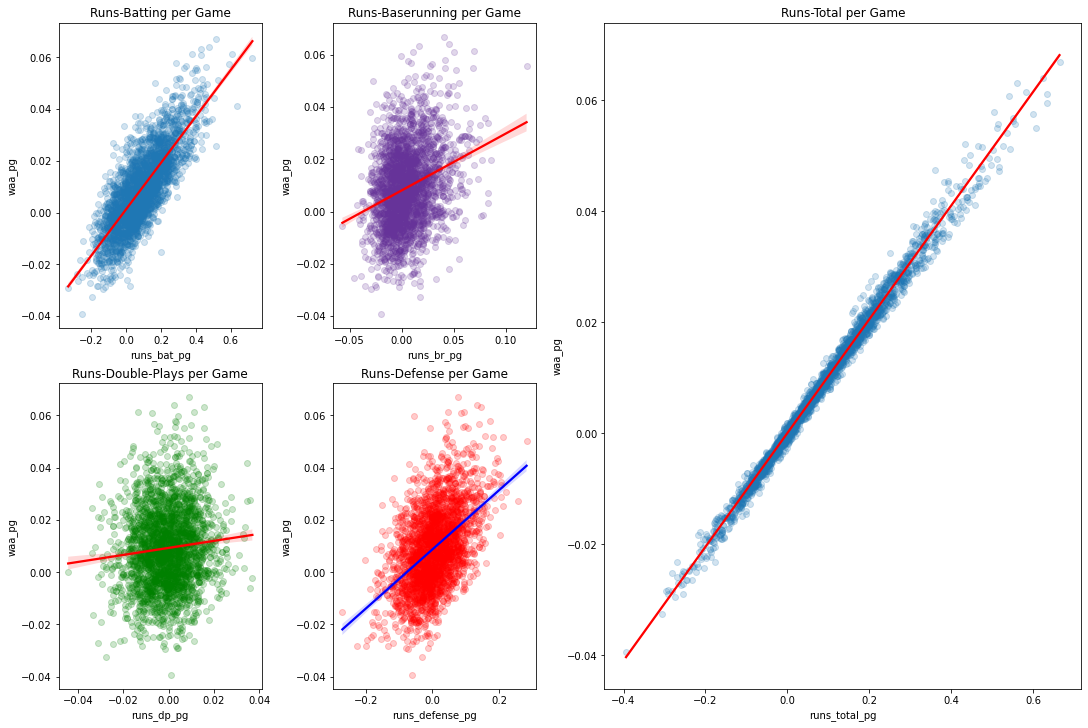

In [6]:
#https://stackoverflow.com/questions/34933905/matplotlib-adding-subplots-to-a-subplot
fig = plt.figure(constrained_layout=True, figsize=(15,10))

subfigs = fig.subfigures(1,2)

axs = subfigs.flat[0].subplots(2,2)
sns.regplot(x='runs_bat_pg', y='waa_pg', data = rdf,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red'},
            ax = axs.flat[0]).set(title = 'Runs-Batting per Game')
sns.regplot(x='runs_br_pg', y='waa_pg', data = rdf,
            scatter_kws={'alpha': 0.2,
                         'color': 'rebeccapurple'},
            line_kws={'color': 'red'},
            ax = axs.flat[1]).set(title = 'Runs-Baserunning per Game')

sns.regplot(x='runs_dp_pg', y='waa_pg', data = rdf,
            scatter_kws={'alpha': 0.2,
                         'color': 'green'},
            line_kws={'color': 'red'},
            ax = axs.flat[2]).set(title = 'Runs-Double-Plays per Game')

sns.regplot(x='runs_defense_pg', y='waa_pg', data = rdf,
            scatter_kws={'alpha': 0.2,
                         'color': 'red'},
            line_kws={'color': 'blue'},
            ax = axs.flat[3]).set(title = 'Runs-Defense per Game')

axs = subfigs.flat[1].subplots(1,1)
sns.regplot(x='runs_total_pg', y='waa_pg', data = rdf,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red'},
            ax = axs).set(title = 'Runs-Total per Game')

plt.show()

**Observation** Our EDA explored the components of runs and how they related to `waa_pg`. When added together, the relationship between `runs_total_pg` and `waa_pg` becomes very very clear.

*Note: runs_position_pg graph omitted*

Similar to our other approach, the present day statistics have no use for our model as they will not exist at the time of forecasting in the real world. Non-run-related features also need to be dropped.

In [7]:
rdf = rdf[['runs_bat_pg_1yr',
       'runs_bat_pg_2yr', 'runs_bat_pg_3yr', 'runs_br_pg_1yr',
       'runs_br_pg_2yr', 'runs_br_pg_3yr', 'runs_dp_pg_1yr', 'runs_dp_pg_2yr',
       'runs_dp_pg_3yr', 'runs_defense_pg_1yr', 'runs_defense_pg_2yr',
       'runs_defense_pg_3yr', 'runs_position_pg_1yr', 'runs_position_pg_2yr',
       'runs_position_pg_3yr','runs_total_pg']]

# RDF EDA

## `runs_bat_pg` vars

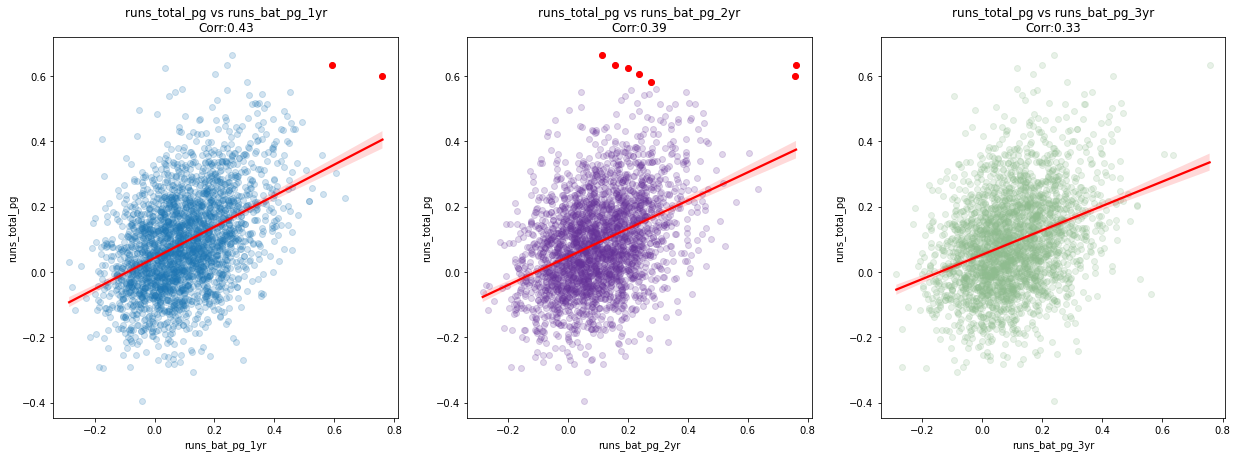

In [8]:
triple_regplot(['runs_bat_pg_1yr','runs_bat_pg_2yr','runs_bat_pg_3yr'], 'runs_total_pg', rdf)
ax = plt.gcf().get_axes()
x_lim = ax[0].get_xlim()

mask=(rdf.runs_bat_pg_1yr>0.55)&(rdf.runs_total_pg>0.55)
mask2=rdf.runs_total_pg>0.58
ax[0].scatter(rdf[mask].runs_bat_pg_1yr, rdf[mask].runs_total_pg, color='red')
ax[1].scatter(rdf[mask2].runs_bat_pg_2yr, rdf[mask2].runs_total_pg, color='red');

Overall pretty positively correlated with the RDF target. Just a few outliers to remove.

In [9]:
rdf=rdf[(~mask)&(~mask2)]

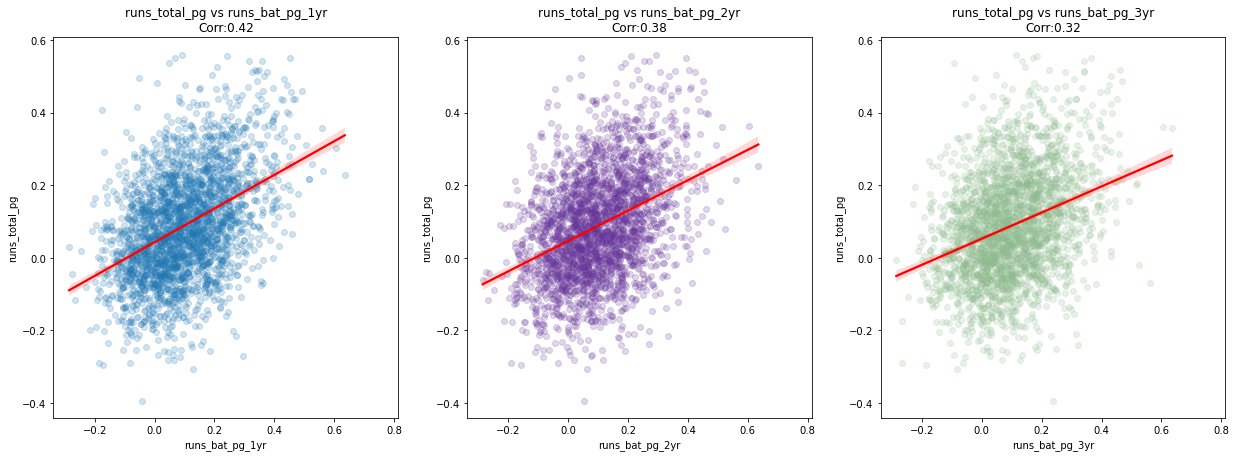

In [10]:
triple_regplot(['runs_bat_pg_1yr','runs_bat_pg_2yr','runs_bat_pg_3yr'], 'runs_total_pg', rdf)
ax = plt.gcf().get_axes()
for i in range(3):
    ax[i].set_xlim(xmin=x_lim[0],xmax=x_lim[1])

## `runs_br_pg` vars

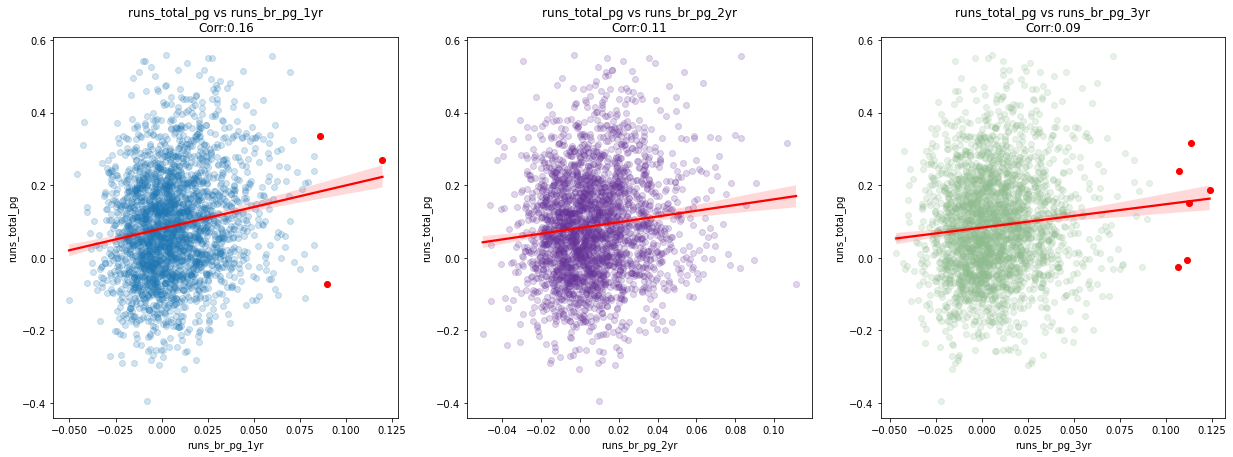

In [11]:
triple_regplot(['runs_br_pg_1yr','runs_br_pg_2yr','runs_br_pg_3yr'],
               'runs_total_pg', rdf)
ax = plt.gcf().get_axes()
x_lim = [ax[i].get_xlim() for i in range(3)]

mask = rdf.runs_br_pg_1yr > 0.085
mask2 = rdf.runs_br_pg_3yr > 0.100
ax[0].scatter(rdf[mask].runs_br_pg_1yr, rdf[mask].runs_total_pg, color='red')
ax[2].scatter(rdf[mask2].runs_br_pg_3yr, rdf[mask2].runs_total_pg, color='red');

Middling correlation, can remove some outliers on the higher end of the x axis to tighten it a little.

In [12]:
rdf=rdf[(~mask)&(~mask2)]

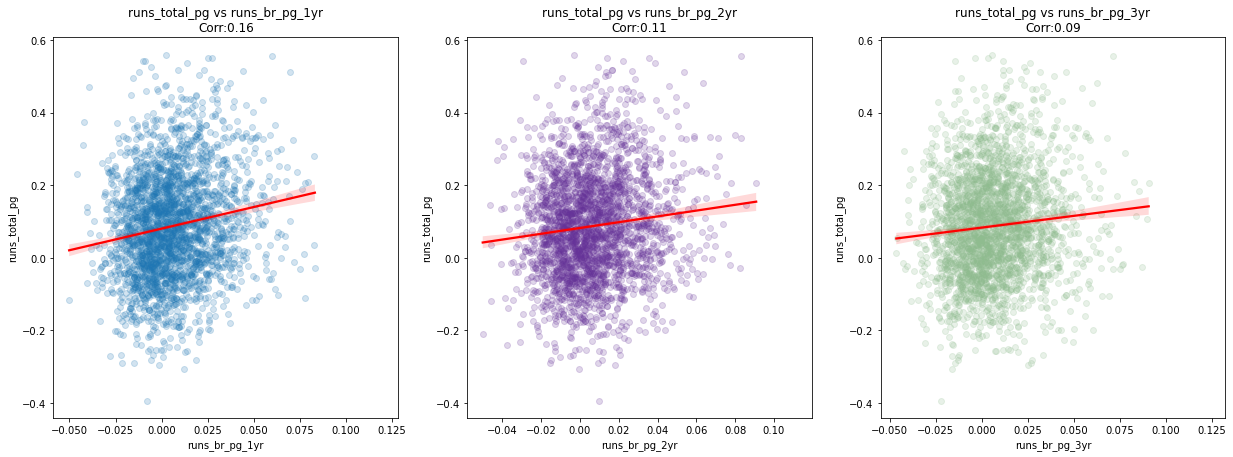

In [13]:
triple_regplot(['runs_br_pg_1yr','runs_br_pg_2yr','runs_br_pg_3yr'],
               'runs_total_pg', rdf)
ax = plt.gcf().get_axes()
for i in range(3):
    ax[i].set_xlim(xmin=x_lim[i][0],xmax=x_lim[i][1])

## `runs_dp_pg` vars

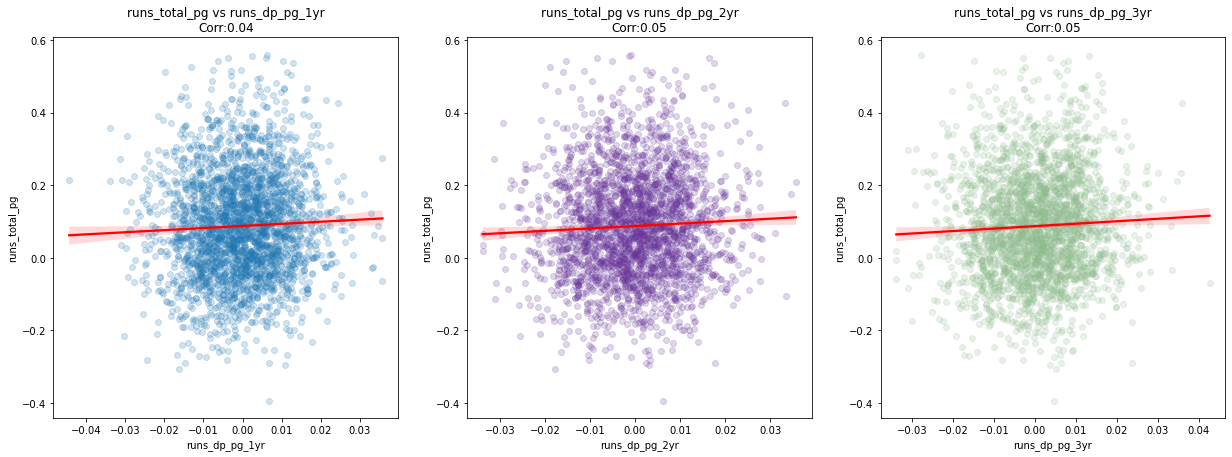

In [14]:
triple_regplot(['runs_dp_pg_1yr','runs_dp_pg_2yr','runs_dp_pg_3yr'],
               'runs_total_pg', rdf)

Expect this to be dropped

## `runs_defense_pg` vars

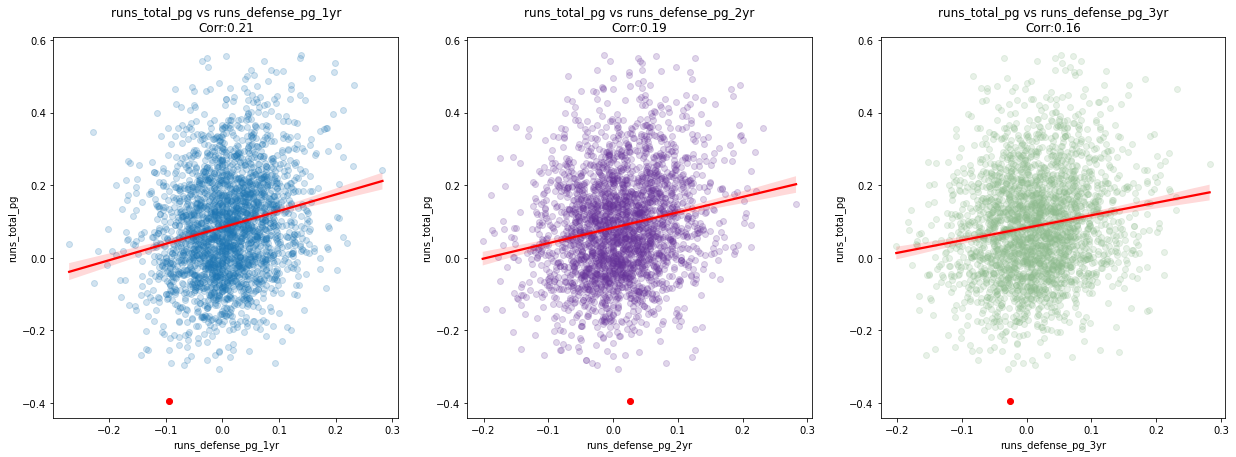

In [15]:
triple_regplot(['runs_defense_pg_1yr','runs_defense_pg_2yr'
                ,'runs_defense_pg_3yr'], 'runs_total_pg', rdf)
ax = plt.gcf().get_axes()
x_lim = [ax[i].get_xlim() for i in range(3)]


mask = rdf.runs_total_pg < -0.35
ax[0].scatter(rdf[mask].runs_defense_pg_1yr, rdf[mask].runs_total_pg, color='red')
ax[1].scatter(rdf[mask].runs_defense_pg_2yr, rdf[mask].runs_total_pg, color='red')
ax[2].scatter(rdf[mask].runs_defense_pg_3yr, rdf[mask].runs_total_pg, color='red');

Moderately positively correlated with the target. Only one outlier to drop.

In [16]:
rdf = rdf[(~mask)]

## `runs_position_pg` vars

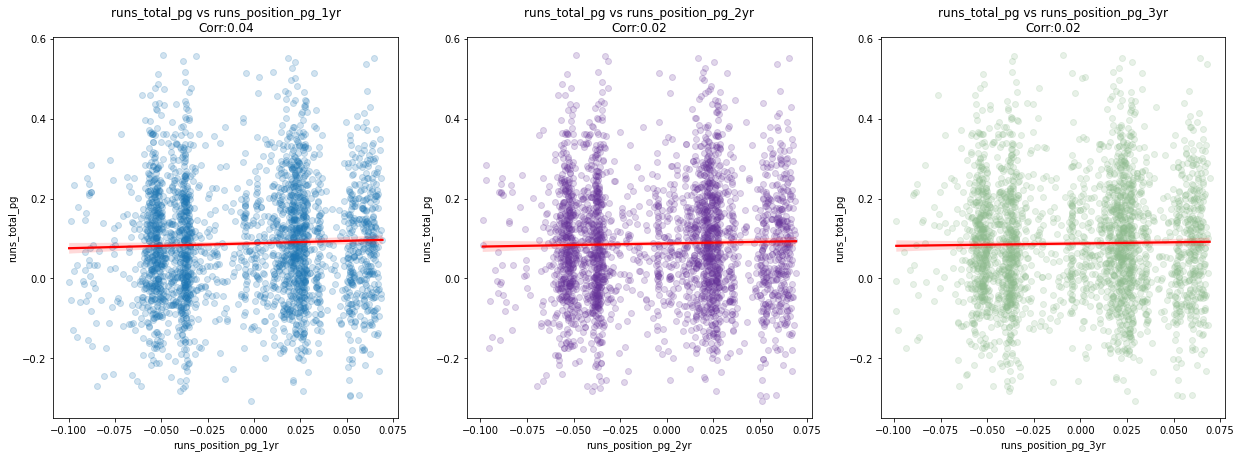

In [17]:
triple_regplot(['runs_position_pg_1yr','runs_position_pg_2yr'
                ,'runs_position_pg_3yr'], 'runs_total_pg', rdf)

Expect this to be dropped

# Year DF Creation

In [18]:
ydf = batpos.copy()

In [19]:
ydf = ydf[['opprpg','opprpg_1yr','opprpg_2yr','opprpg_3yr']]

# YDF EDA

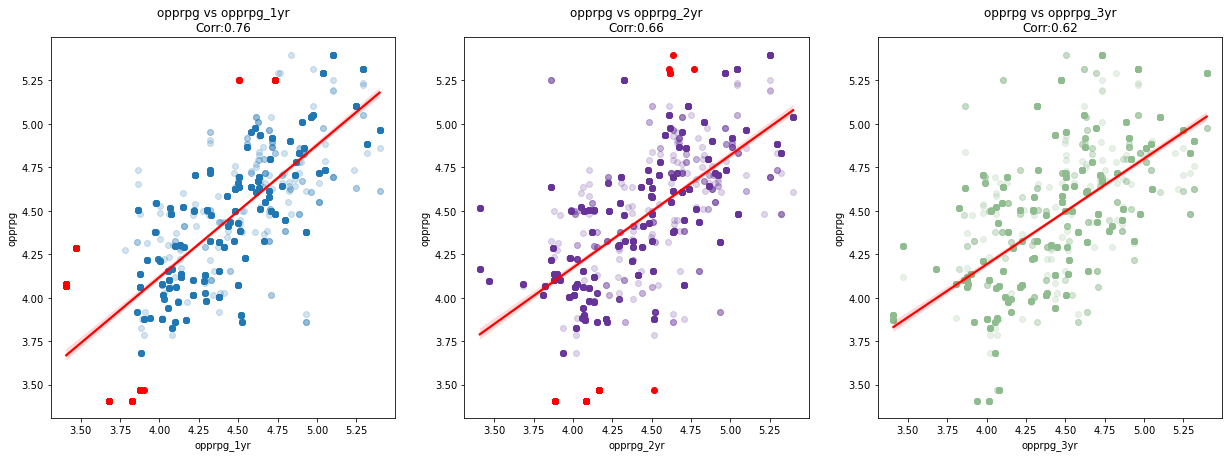

In [20]:
triple_regplot(['opprpg_1yr','opprpg_2yr'
                ,'opprpg_3yr'], 'opprpg', ydf)
ax = plt.gcf().get_axes()
y_lim = ax[0].get_ylim()

mask = ydf.opprpg_1yr<3.50
mask2 = ydf.opprpg<3.50
mask3 = (ydf.opprpg_1yr.between(4.4,4.75))&(ydf.opprpg.between(5.2,5.5))
mask4 = ydf.opprpg < 3.57
mask5 = (ydf.opprpg_2yr.between(4.5,4.8))&(ydf.opprpg.between(5.2,5.45))
ax[0].scatter(ydf[mask|mask2|mask3].opprpg_1yr, ydf[mask|mask2|mask3].opprpg, color='red')
ax[1].scatter(ydf[mask4|mask5].opprpg_2yr, ydf[mask4|mask5].opprpg, color='red');

Overall very strong correlation with just a few outliers to remove.

In [21]:
ydf = ydf[(~mask)&(~mask2)&(~mask3)&(~mask4)&(~mask5)]

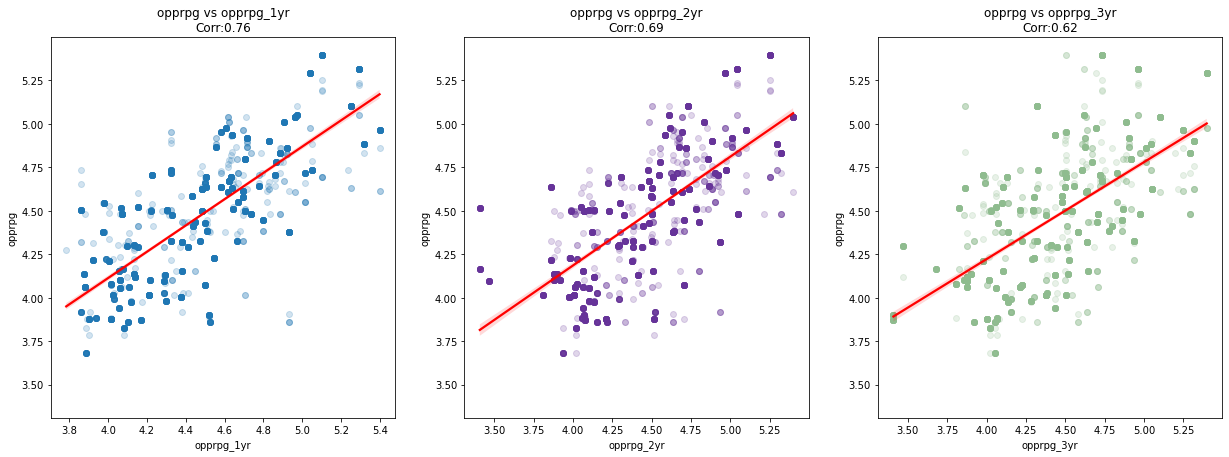

In [22]:
triple_regplot(['opprpg_1yr','opprpg_2yr'
                ,'opprpg_3yr'], 'opprpg', ydf)
ax = plt.gcf().get_axes()
for i in range(3):
    ax[i].set_ylim(ymin=y_lim[0],ymax=y_lim[1])


# Remaining Vars

In [23]:
others = batpos.copy()

In [24]:
target_year_vars=\
['g', 'team_gp', 'pa_pg', 'inn_pg',
'runs_bat_pg', 'runs_br_pg', 'runs_dp_pg', 'runs_defense_pg',
'runs_position_pg', 'percent_team_gp', 'pa_per_team_gp',
'inn_per_team_gp', 'g_c_share', 'g_1b_share', 'g_2b_share',
'g_3b_share', 'g_ss_share', 'g_cf_share', 'g_of', 'g_dh_share',
'g_cof_share']

In [25]:
others=others[[c for c in batpos.columns if c not in rdf.columns
                                  if c not in ydf.columns
                                  if c not in target_year_vars
                                  if c not in ['player_id','name_common']]]

# Remaining Vars EDA

## `waa_pg` vars

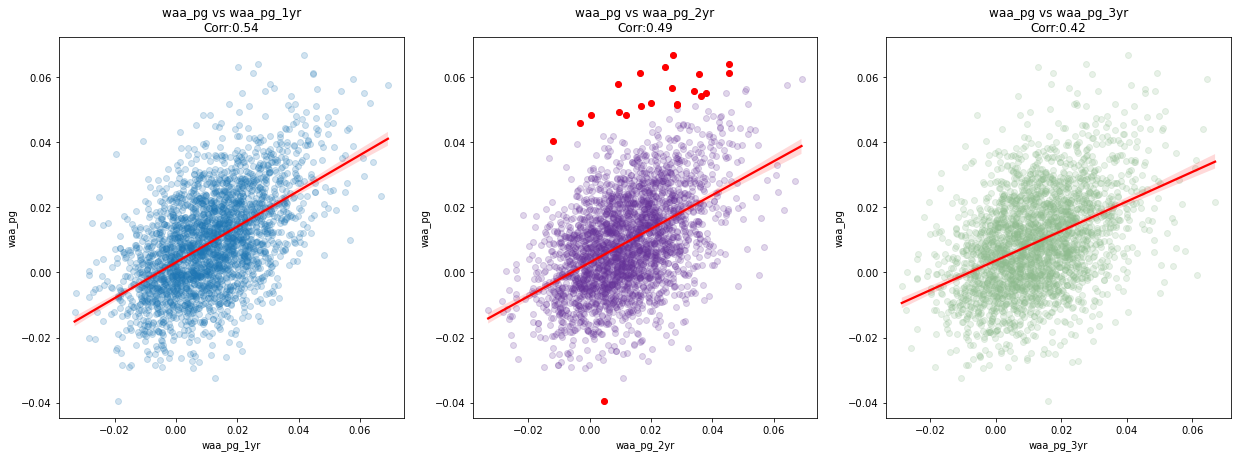

In [26]:
triple_regplot(['waa_pg_1yr','waa_pg_2yr','waa_pg_3yr'], 'waa_pg', others)
ax = plt.gcf().get_axes()
y_lim = ax[0].get_ylim()

mask = others.waa_pg >\
        (.03/.10)*others.waa_pg_2yr + 0.06 - (.03/.10)*0.06
mask2 = others.waa_pg <\
        (-.01/.10)*others.waa_pg_2yr - 0.04 - (-.01/.10)*0.06
ax[1].scatter(others[mask|mask2].waa_pg_2yr, others[mask|mask2].waa_pg, color='red');

In [27]:
others = others[(~mask)&(~mask2)]

## `pa_pg` vars

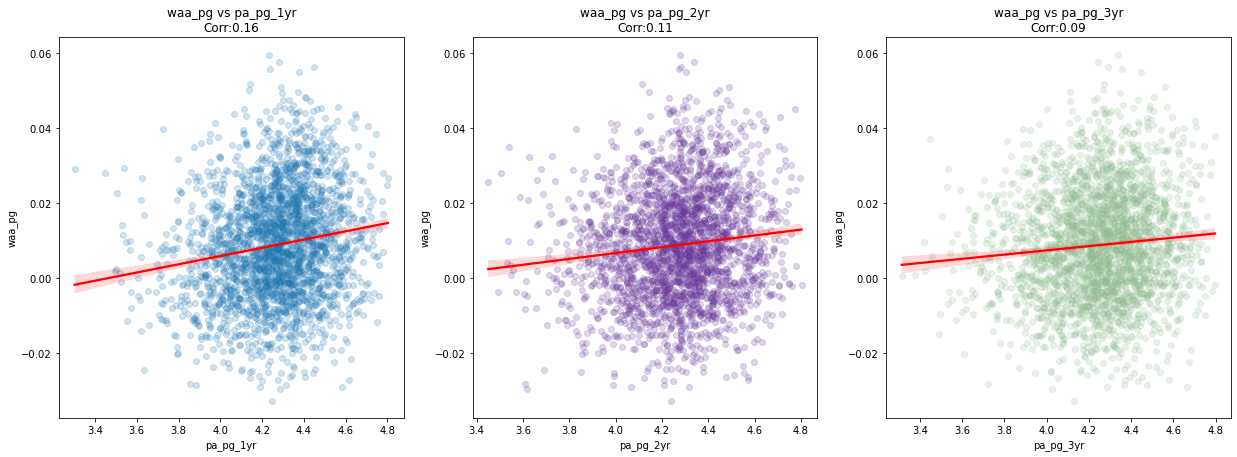

In [28]:
triple_regplot(['pa_pg_1yr','pa_pg_2yr','pa_pg_3yr'], 'waa_pg', others)

This is a pretty weak correlation. Avoid dropping outliers here.

## `inn_pg` vars

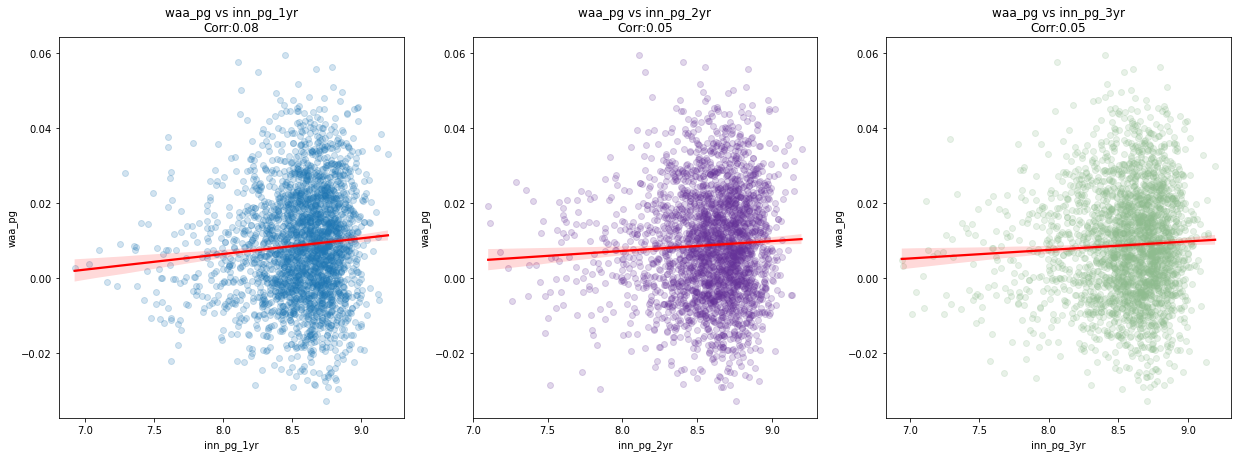

In [29]:
triple_regplot(['inn_pg_1yr','inn_pg_2yr','inn_pg_3yr'], 'waa_pg', others)

This is a pretty weak correlation. Avoid dropping outliers here.

## `percent_team_gp` vars

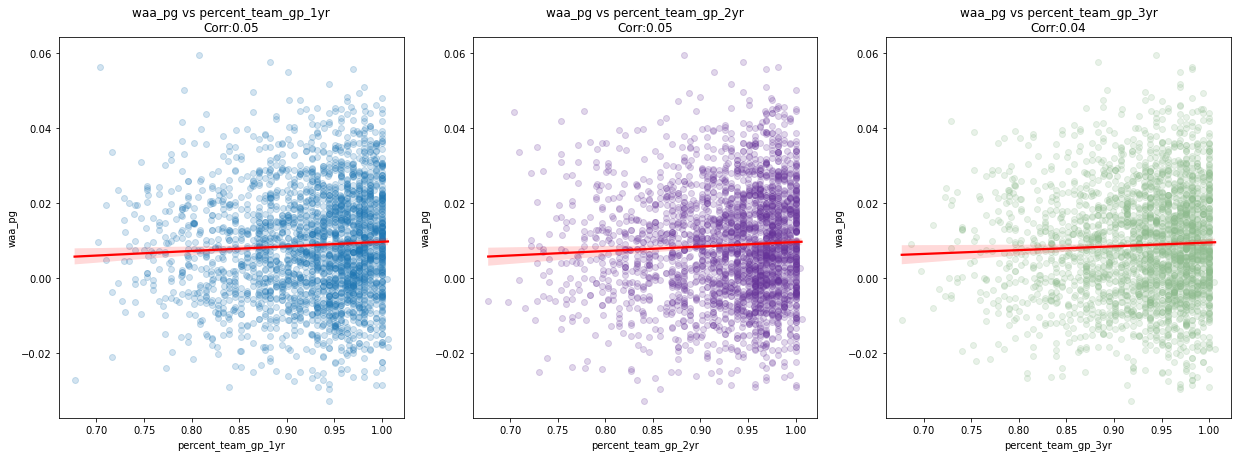

In [30]:
triple_regplot(['percent_team_gp_1yr','percent_team_gp_2yr'
                ,'percent_team_gp_3yr'], 'waa_pg', others)

Expect this to be dropped

## `pa_per_team_gp` vars

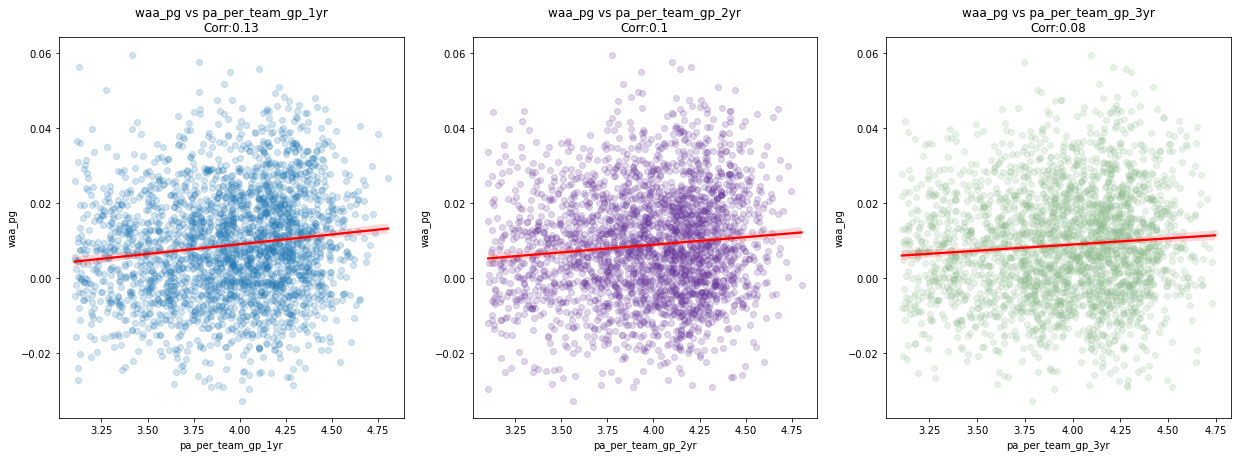

In [31]:
triple_regplot(['pa_per_team_gp_1yr','pa_per_team_gp_2yr'
                ,'pa_per_team_gp_3yr'], 'waa_pg', others)

This is a pretty weak correlation. Avoid dropping outliers here.

## `inn_per_team_gp` vars

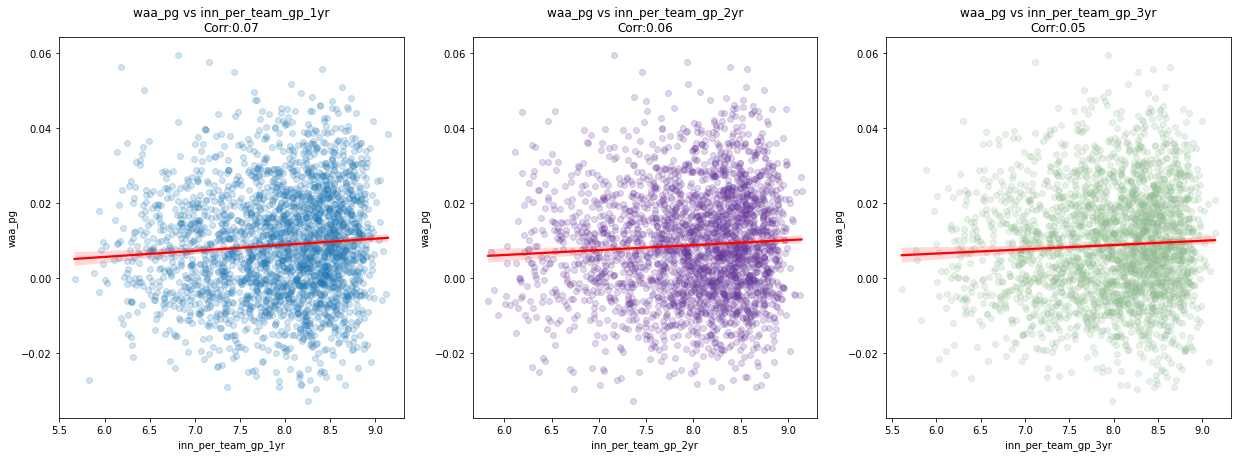

In [32]:
triple_regplot(['inn_per_team_gp_1yr','inn_per_team_gp_2yr'
                ,'inn_per_team_gp_3yr'], 'waa_pg', others)

Expect this to be dropped.

## positional shares

In [33]:
pos = ['g_c_share_1yr', 'g_c_share_2yr', 'g_c_share_3yr', 'g_1b_share_1yr',
       'g_1b_share_2yr', 'g_1b_share_3yr', 'g_2b_share_1yr', 'g_2b_share_2yr',
       'g_2b_share_3yr', 'g_3b_share_1yr', 'g_3b_share_2yr', 'g_3b_share_3yr',
       'g_ss_share_1yr', 'g_ss_share_2yr', 'g_ss_share_3yr', 'g_cf_share_1yr',
       'g_cf_share_2yr', 'g_cf_share_3yr', 'g_of_1yr', 'g_of_2yr', 'g_of_3yr',
       'g_dh_share_1yr', 'g_dh_share_2yr', 'g_dh_share_3yr', 'g_cof_share_1yr',
       'g_cof_share_2yr', 'g_cof_share_3yr'][::-1]

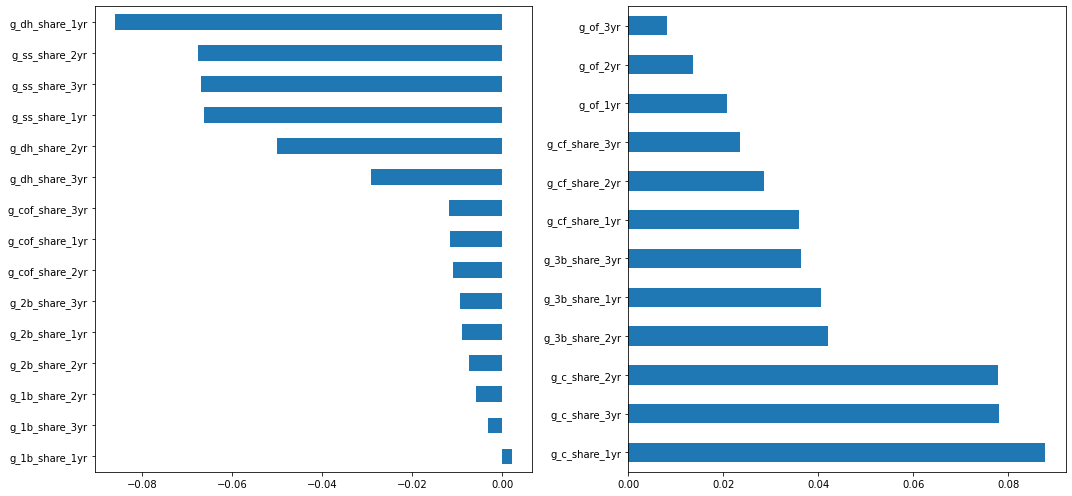

In [34]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

others.corr().loc['waa_pg',pos].sort_values()[:15][::-1].plot(kind='barh',ax=ax[0])
others.corr().loc['waa_pg',pos].sort_values()[15:][::-1].plot(kind='barh',ax=ax[1])
plt.tight_layout()

**Observation** From this we can see that DH, SS, and C all have the most effect on runs_total_pg.

**Note** Despite this, the highest absolute correlation coefficient is still below 0.10. Every single one of these I would expect to see dropped during preprocessing.

# Exports

In [35]:
rdf_ydf = pd.merge(
            pd.merge(rdf,ydf,
                     how='inner',
                     left_index=True, right_index=True),
            others,
            how='inner',
            left_index=True, right_index=True)

In [36]:
rdf_ydf.to_csv('../data/rdf_ydf_feature_extracted.csv', index=False)